## Twitter Sentiment Analysis

The objective is to identify positive , hate and neutral speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexiest sentiment associated with it.

In [1]:
## Importing required libraries 
import re 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn import svm

D:\Anaconda\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
#importing training and testing dataset from 
train_data= pd.read_csv(r'D:\twiter_train.csv')
test_data= pd.read_csv(r'D:\twiter_test.csv')

In [3]:
train_data.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


**Dataset consist of below field**

* ID - Unique id of tweet
* Label - sentiment of tweet
* Tweet - text of the tweet

In [5]:
print("Total Number of tweet for training:",train_data.shape[0])
print("Total Number of tweet for testing:",test_data.shape[0])

Total Number of tweet for training: 31962
Total Number of tweet for testing: 17197


## Data Preprocessing

In [6]:
train_data["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Text(0, 0.5, 'Frequency')

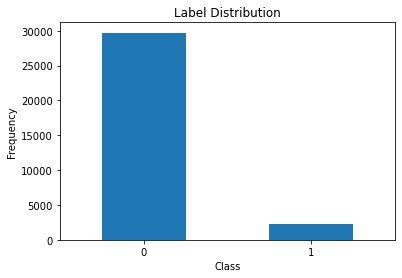

In [7]:
count_classes = pd.value_counts(train_data['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Label Distribution")

# plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

**Data set is imbalance as we have 7% of data with label 1 and 93% of data with label 0 **

In [8]:
#Combining training and testing data for data cleaning
Combine= train_data.append(test_data, ignore_index=True)


* These Twitter handles are hardly giving any information about the nature of the tweet.
* The punctuations, numbers and even special characters wouldn’t help in differentiating different kinds of tweets.
* Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

In [9]:
Combine['tweet'] = Combine['tweet'].str.replace('@[\w]*', '')
Combine['tweet'] = Combine['tweet'].str.replace('[^a-zA-Z#\s]', '')

In [10]:
Combine['tweet'] = Combine['tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
Combine.head()

,id,label,tweet
0,1,0.0,when father dysfunctional selfish drags kids i...
1,2,0.0,thanks #lyft credit cant cause they dont offer...
2,3,0.0,bihday your majesty
3,4,0.0,#model love take with time
4,5,0.0,factsguide society #motivation


In [11]:
#stemming
tokenize_tweet= Combine['tweet'].apply(lambda x: x.split())
stemmer=PorterStemmer()
tokenize_tweet = tokenize_tweet.apply(lambda x:[stemmer.stem(i) for i in x])

# Sentences
for i in range(len(tokenize_tweet)):
    tokenize_tweet[i]=' '.join(tokenize_tweet[i])
Combine['tweet']=tokenize_tweet

In [12]:
Combine.head(10)

,id,label,tweet
0,1,0.0,when father dysfunct selfish drag kid into dys...
1,2,0.0,thank #lyft credit cant caus they dont offer w...
2,3,0.0,bihday your majesti
3,4,0.0,#model love take with time
4,5,0.0,factsguid societi #motiv
5,6,0.0,huge fare talk befor they leav chao disput whe...
6,7,0.0,camp tomorrow danni
7,8,0.0,next school year year exam cant think about th...
8,9,0.0,love land #allin #cav #champion #cleveland #cl...
9,10,0.0,welcom here


A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

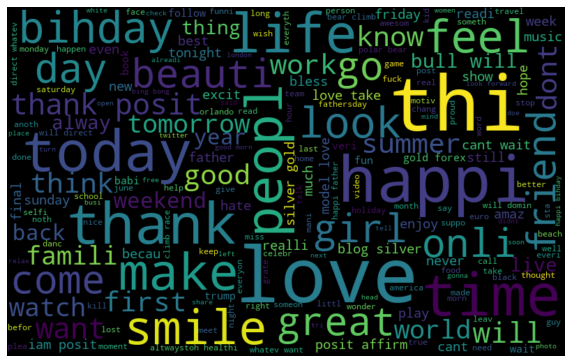

In [13]:
All_Words= ' '.join([text for text in Combine['tweet']])
wordcloud = WordCloud(width=800, height =500, random_state=21, max_font_size=110).generate(All_Words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy and love being the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes(racist/sexist or not) in our train data.

**Words in non racist/sexist tweets**

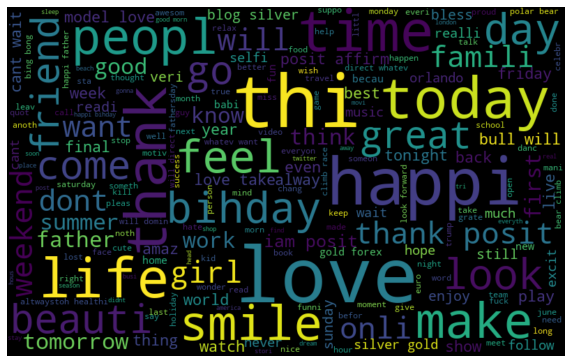

In [14]:
Z_Words= ' '.join([text for text in Combine['tweet'][Combine['label']==0]])
wordcloud = WordCloud(width=800, height =500, random_state=21, max_font_size=110).generate(Z_Words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy, smile, and love being the most frequent ones. Hence, most of the frequent words are compatible with the sentiment which is non racist/sexists tweets.

**Racist/Sexist Tweets**

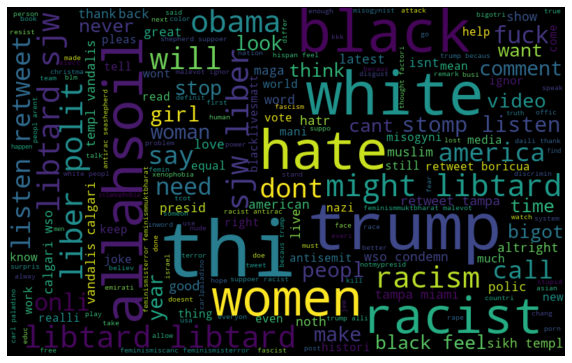

In [15]:
ZZ_Words= ' '.join([text for text in Combine['tweet'][Combine['label']==1]])
wordcloud = WordCloud(width=800, height =500, random_state=21, max_font_size=110).generate(ZZ_Words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

Most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

In [16]:
def extract_hashtag(x):
    hastag=[]
    for i in x:
        ht = re.findall(r"#[\w]*",i)
        hastag.append(ht)
    return hastag

hastag_pos = extract_hashtag(Combine['tweet'][Combine['label']==0])
hastag_neg = extract_hashtag(Combine['tweet'][Combine['label']==1])

HT_Pos = sum(hastag_pos,[])
HT_Neg = sum(hastag_neg,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top n hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

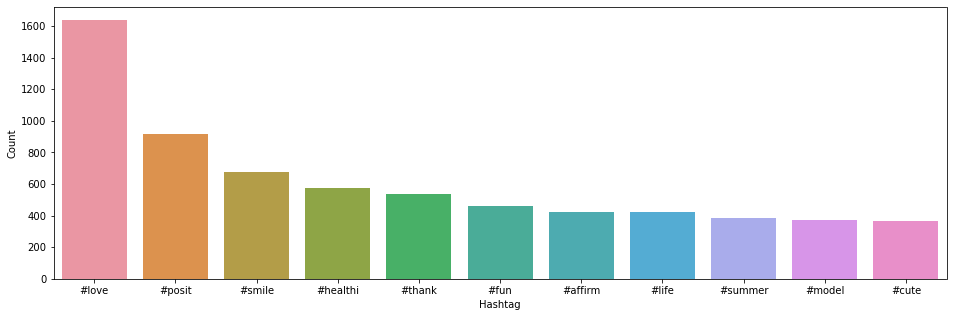

In [17]:
a=nltk.FreqDist(HT_Pos)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 11) 
plt.figure(figsize=(16,5))
ax= sns.barplot(data=d, x='Hashtag', y='Count')
ax.set(ylabel='Count')
plt.show()


All these hashtags are positive and it makes sense. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

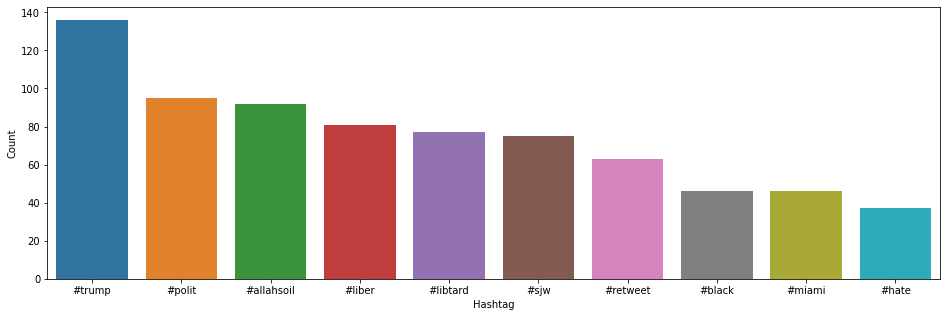

In [18]:
a=nltk.FreqDist(HT_Neg)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax= sns.barplot(data=d, x='Hashtag', y='Count')
ax.set(ylabel='Count')
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. 

To analyze a preprocessed data, it needs to be converted into features.

## Extracting Features

**Bag-of-Words Features**

Bag-of-Words is a method to represent text into numerical features. Consider a corpus (a collection of texts) called C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. 

In [19]:
#Each tweet is converted into vector
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(Combine['tweet'])
bow.shape

(49159, 2000)

## TF-IDF Features

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(Combine['tweet'])
tfidf.shape

(49159, 2000)

## Word Vectorization (Word Embedding)

Word vectorization is the process of mapping words to a set of real numbers or vectors. 

In [21]:
tokenized_tweet = Combine['tweet'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tokenized_tweet,size =200, window=5, min_count=2 , sg= 1, hs =0, negative=10, workers=2, seed = 34)
model_w2v.train(tokenized_tweet, total_examples= len(Combine['tweet']), epochs=20)

(6512877, 7591760)

In [22]:
#words similar to dinner
model_w2v.wv.most_similar(positive= "dinner")


[('spaghetti', 0.5849791765213013),
 ('dess', 0.5615867972373962),
 ('#cellar', 0.5582890510559082),
 ('#biall', 0.555298924446106),
 ('fav', 0.5449811220169067),
 ('#avocado', 0.5403487086296082),
 ('hampton', 0.5399351716041565),
 ('#toast', 0.539620041847229),
 ('lukey', 0.5393368601799011),
 ('spinach', 0.5383566617965698)]

In [23]:
#function to create a vector for each tweet by taking average of vectors of words present in the tweet

def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

<ipython-input-23-6fe194e3ff16>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(49159, 200)

## Doc2vec Embedding

Doc2Vec is unsupervised algorithm to generate vectors for sentences/paraghrap/documents. To implement Doc2Vec we have to labelize or tag each tokenize tweet with unique ID

In [24]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output
labeled_tweets = add_label(tokenized_tweet)
labeled_tweets[:6]

<ipython-input-24-5203b6bc490a>:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


[LabeledSentence(words=['when', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'into', 'dysfunct', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thank', '#lyft', 'credit', 'cant', 'caus', 'they', 'dont', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesti'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguid', 'societi', '#motiv'], tags=['tweet_4']),
 LabeledSentence(words=['huge', 'fare', 'talk', 'befor', 'they', 'leav', 'chao', 'disput', 'when', 'they', 'there', '#allshowandnogo'], tags=['tweet_5'])]

In [25]:
#Train Doc2Vec
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

D:\Anaconda\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|████████████████████████████████████████████████████████████████████████| 49159/49159 [00:00<00:00, 353871.43it/s]


In [26]:
model_d2v.train(labeled_tweets, total_examples= len(Combine['tweet']), epochs=15)

In [27]:
#Preparing doc2vec feature set
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(Combine)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.191227,0.102173,0.055342,-0.260511,-0.152365,0.173511,-0.232976,0.082990,0.181669,-0.453475,...,0.091599,-0.087752,-0.043269,-0.000213,0.067707,0.056879,-0.288976,0.086751,-0.014174,-0.320748
1,0.342049,-0.028277,-0.071558,-0.308675,0.423889,-0.234650,0.393225,0.166366,0.053779,0.040373,...,0.235343,-0.309643,-0.148690,0.043493,0.226035,-0.064754,-0.088468,0.241607,-0.106706,-0.371393
2,0.149117,-0.051965,0.034326,0.127494,0.236387,-0.023544,0.095139,-0.000501,-0.106526,0.126264,...,-0.153351,-0.058602,-0.184476,-0.169331,0.065842,0.040961,-0.059920,0.000028,-0.027419,0.094474
3,0.013575,0.048187,0.099818,0.071137,0.236894,-0.136362,-0.017177,-0.011149,-0.144158,0.070342,...,-0.034427,-0.058835,-0.156966,-0.144119,0.086553,-0.008330,0.065076,-0.056834,-0.049116,-0.033334
4,0.058173,-0.016570,-0.061267,0.016295,0.141359,-0.076779,0.023671,-0.118256,-0.138595,0.053164,...,0.064257,-0.075645,-0.036379,-0.100572,0.134842,-0.094119,-0.077338,-0.130727,-0.209902,-0.048131


**Try to fit logistic Regression model on Bag of words Feature**

In [28]:
#BAG with Logistic Regression

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

xtrain_bow,xvalid_bow,ytrain,yvalid = train_test_split(train_bow, train_data['label'],random_state = 42,test_size = 0.3)


In [29]:
#Random Over Sampling
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
ros = RandomOverSampler(random_state=777)
ros_xtrain_bow, ros_ytrain_bow = ros.fit_sample(train_bow, train_data['label'])

In [30]:
ros_ytrain_bow.value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [31]:
xtrain_bow,xvalid_bow,ytrain,yvalid = train_test_split(ros_xtrain_bow, ros_ytrain_bow,random_state = 42,test_size = 0.3)
lreg = LogisticRegression()
lreg.fit(xtrain_bow,ytrain)
prediction =lreg.predict_proba(xvalid_bow)
prediction_int = prediction[:,1]>=0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9078424286230574

In [32]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test_data['label']= test_pred_int
submission = test_data[['id','tweet','label']]

In [33]:
submission.head()

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedic...,1
1,31964,@user #white #supremacists want everyone to s...,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,0
3,31966,is the hp and the cursed child book up for res...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",0


**We will follow same step but with TFIDF feature**

In [34]:

train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf,xvalid_tfidf,ytrain,yvalid = train_test_split(train_tfidf, train_data['label'],random_state = 42,test_size = 0.3)
lreg.fit(xtrain_tfidf,ytrain)
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid,prediction_int)

0.5667574931880109

In [36]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]
xtrain_w2v = train_w2v.iloc[ytrain.index]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v,ytrain)
prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1]>=0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.6284437825763216

In [37]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:]
xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]
lreg.fit(xtrain_d2v,ytrain)
prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid,prediction_int)

0.36475770925110135

In [38]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:]
d2v = RandomOverSampler(random_state=777)
d2v_xtrain, d2v_ytrain= d2v.fit_sample(train_d2v, train_data['label'])
xtrain_d2v,xvalid_d2v,ytrain,yvalid = train_test_split(d2v_xtrain, d2v_ytrain,random_state = 42,test_size = 0.3)
lreg.fit(xtrain_d2v,ytrain)
prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid,prediction_int)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7676999617298124

**AS we can see f1 score is low for unbalance data and high for balance data, So it's good practice to build model on balance data**

In [39]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 600, random_state=11).fit(xtrain_bow, ytrain)
prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.959094865100087

In [40]:
test_pred = rf.predict(test_bow)
test_data['label'] = test_pred
submission = test_data[['id','tweet','label']]
submission.head()

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedic...,0
1,31964,@user #white #supremacists want everyone to s...,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,0
3,31966,is the hp and the cursed child book up for res...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",0


In [41]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=6, n_estimators= 1000).fit(xtrain_bow,ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

                                                              

0.9615556548949485

In [42]:
test_pred = xgb_model.predict(test_bow)
test_data['label'] = test_pred
submission = test_data[['id','tweet','label']]
submission.head()

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedic...,0
1,31964,@user #white #supremacists want everyone to s...,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,0
3,31966,is the hp and the cursed child book up for res...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",0
